In [ ]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Necessary libraries
import os 
# Set Directory path for Dataset for Assia
os.chdir("/content/drive/My Drive/Covid19-Newspaper-Topic-Modeling")

In [ ]:
# setting up our imports
%matplotlib inline
import pickle
from pprint import pprint
import random
import warnings
import time
import numpy as np
import pandas as pd

In [ ]:
print("Loading Data...")
dataset = pd.read_csv('Text_labeled.csv')

Loading Data...


In [ ]:
dataset

,Unnamed: 0,Text_en,Text_en_clean,data_words,data_ready,Topics
0,0,Highest number of Covid-19 deaths in a day. Ni...,highest number of covid deaths in a day ninete...,"['highest', 'number', 'covid', 'death', 'day',...","['high', 'number', 'death', 'day', 'people', '...",6.0
1,1,"Thrown out of job, Tangail’s chamcham makers p...",thrown out of job tangails chamcham makers pas...,"['thrown', 'job', 'tangails', 'chamcham', 'mak...","['throw', 'job', 'tangail', 'maker', 'hard', '...",1.0
2,2,Coping with Covid-19 Shutdown: 200 families re...,coping with covid shutdown families reaping b...,"['coping', 'covid', 'shutdown', 'family', 'rea...","['cope', 'covid', 'shutdown', 'family', 'reapi...",3.0
3,3,"7 family members, 4 police personnel test posi...",family members police personnel test positiv...,"['family', 'member', 'police', 'personnel', 't...","['family', 'member', 'test', 'positive', 'bogu...",4.0
4,4,Coronavirus: Health ministry issues 13 directi...,coronavirus health ministry issues directives...,"['coronavirus', 'health', 'ministry', 'issue',...","['issue', 'official', 'effort', 'contain', 'to...",1.0
...,...,...,...,...,...,...
15560,15560,The number of victims and deaths is increasing...,the number of victims and deaths is increasing...,"['number', 'victim', 'death', 'increasing', 'l...","['number', 'victim', 'death']",6.0
15561,15561,India returns passengers in fear of coronaviru...,india returns passengers in fear of coronaviru...,"['india', 'return', 'passenger', 'fear', 'coro...","['passenger', 'fear']",0.0
15562,15562,Instructions to bring back the Bangladeshis tr...,instructions to bring back the bangladeshis tr...,"['instruction', 'bring', 'back', 'bangladeshi'...","['instruction', 'trap', 'direct', 'strand', 'r...",2.0
15563,15563,Coronavirus: Control room opened in the Depart...,coronavirus control room opened in the departm...,"['coronavirus', 'control', 'room', 'opened', '...","['open', 'department', 'health']",4.0


In [ ]:
dataset.shape

(15565, 6)

Data exploration

In [ ]:
dataset['topics_id'] = dataset['Topics'].factorize()[0]

In [ ]:
dataset.groupby('Topics').topics_id.count()

Topics
0.0     509
1.0    1680
2.0    1865
3.0    2058
4.0    4674
5.0     915
6.0    3018
7.0     846
Name: topics_id, dtype: int64

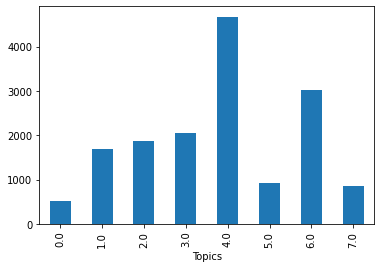

In [ ]:
dataset.groupby('Topics').topics_id.count().plot.bar(ylim=0)

Data analysis

In [ ]:
# Count nan values
dataset.isna().sum()

Unnamed: 0       0
Text_en          5
Text_en_clean    5
data_words       0
data_ready       0
Topics           0
topics_id        0
dtype: int64

In [ ]:
# Drop na
dataset.dropna(inplace = True)
dataset.reset_index(drop = True, inplace=True)

In [ ]:
dataset.isna().sum()

Unnamed: 0       0
Text_en          0
Text_en_clean    0
data_words       0
data_ready       0
Topics           0
topics_id        0
dtype: int64

In [ ]:
corpus = dataset['data_ready'].copy()

In [ ]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
MAX_FEATURES = 10000
cv = CountVectorizer(max_features=MAX_FEATURES)
X = cv.fit_transform(corpus).toarray()

In [ ]:
y=dataset['Topics'].values

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

models = [
    
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=3)
]

In [ ]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


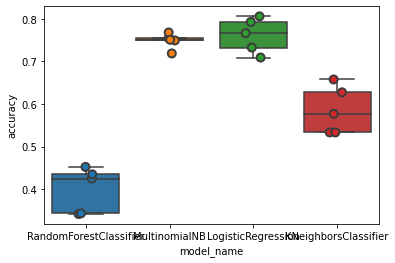

In [ ]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier      0.585994
LogisticRegression        0.761452
MultinomialNB             0.748474
RandomForestClassifier    0.399807
Name: accuracy, dtype: float64

Split to train and test data for Multinomial and LogisticRegression

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [ ]:
X_train.shape,y_train.shape

((12448, 10000), (12448,))

Multinomial Naive Bayes

In [ ]:
# Training model using Naive bayes classifier

from sklearn.naive_bayes import MultinomialNB
naive_Bayes = MultinomialNB().fit(X_train, y_train)

y_pred= naive_Bayes.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm_mnb = confusion_matrix(y_test, y_pred)
cm_mnb

array([[ 67,   6,   4,  10,  16,   1,   0,   0],
       [  1, 269,  13,  13,  21,  10,   4,   1],
       [  0,  13, 299,   5,  26,   3,   4,   2],
       [  2,  14,  13, 335,   8,   2,  19,  14],
       [  0,  14,   7,   5, 930,   0,  16,   1],
       [  0,   4,   9,  12,   2, 141,   1,   3],
       [  0,   2,   2,   5,  60,   2, 534,   2],
       [  0,   3,   5,   6,   3,   1,   4, 143]])

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred, average = 'weighted'))
print("Precision score: ", precision_score(y_test, y_pred, average = 'weighted'))
print("F1 score: ", f1_score(y_test, y_pred, average = 'weighted'))

nb = []
nb.append(accuracy_score(y_test, y_pred))
nb.append(recall_score(y_test, y_pred, average = 'weighted'))
nb.append(precision_score(y_test, y_pred, average = 'weighted'))
nb.append(f1_score(y_test, y_pred, average = 'weighted'))

Accuracy score:  0.8733933161953727
Recall score:  0.8733933161953727
Precision score:  0.8745378397536628
F1 score:  0.8721559241486042


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


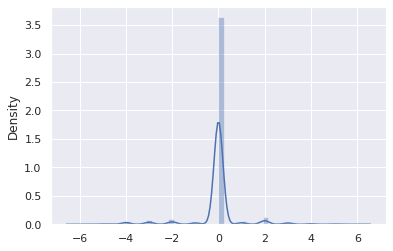

In [ ]:
sns.distplot(y_test-y_pred)
plt.show()

Logistique Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_Regression = LogisticRegression().fit(X_train, y_train)

y_pred = logistic_Regression.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred)
cm_lr

array([[ 67,   9,   4,   3,  17,   2,   1,   1],
       [  1, 267,  14,  12,  28,   4,   6,   0],
       [  2,  19, 283,   5,  30,   3,   3,   7],
       [  5,  17,  13, 296,  35,   9,  26,   6],
       [  3,  11,   9,   5, 918,   1,  24,   2],
       [  0,  11,  17,  10,  10, 119,   3,   2],
       [  0,   3,   4,   3,  36,   3, 557,   1],
       [  1,   1,   5,   8,  20,   4,  13, 113]])

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred, average = 'weighted'))
print("Precision score: ", precision_score(y_test, y_pred, average = 'weighted'))
print("F1 score: ", f1_score(y_test, y_pred, average = 'weighted'))

lg = []
lg.append(accuracy_score(y_test, y_pred))
lg.append(recall_score(y_test, y_pred, average = 'weighted'))
lg.append(precision_score(y_test, y_pred, average = 'weighted'))
lg.append(f1_score(y_test, y_pred, average = 'weighted'))

Accuracy score:  0.8419023136246787
Recall score:  0.8419023136246787
Precision score:  0.8422716273109935
F1 score:  0.8389891032343839


Hyperparameter Tuning

Multinomial Naive Bayes Parameters:

-alpha: a paramter for smoothing (1.0) <br>
-class_prior: looking at the previous class probability (None) attributes <br>
-feature_count: number of samples for each class or feature (number of classes, number of features) <br>
-n_features: number of features for sample

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

Stack overflow link explanation for class_prior : https://stackoverflow.com/questions/46449690/scikit-learn-randomizedsearchcv-not-working-for-class-prior-in-multinomialnb

In [ ]:
alpha = [0,0.2,0.4,0.6,1]
class_prior = [[uniform.rvs(0,3), uniform.rvs(0,3), uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3)],
               [uniform.rvs(0,3), uniform.rvs(0,3), uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3)],
               [uniform.rvs(0,3), uniform.rvs(0,3), uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3)],
               [uniform.rvs(0,3), uniform.rvs(0,3), uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3)],
               [uniform.rvs(0,3), uniform.rvs(0,3), uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3)],
               [uniform.rvs(0,3), uniform.rvs(0,3), uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3)],
               [uniform.rvs(0,3), uniform.rvs(0,3), uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3)],
               [uniform.rvs(0,3), uniform.rvs(0,3), uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3),uniform.rvs(0,3)]]
fit_prior = ['True', 'False']

In [ ]:
from scipy.stats import uniform
tuned_parameters = {'alpha' : alpha,
                    'class_prior': class_prior,
                    'fit_prior': fit_prior}

In [ ]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
nb_random = RandomizedSearchCV(estimator = MultinomialNB(), param_distributions = tuned_parameters,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [ ]:
nb_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] fit_prior=True, class_prior=[1.6143057028673264, 2.2561552010679744, 2.0530953364758764, 1.4665885301373107, 0.27855653871793506, 0.8663691388868232, 0.028621625191021738, 1.1946461545652527], alpha=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  fit_prior=True, class_prior=[1.6143057028673264, 2.2561552010679744, 2.0530953364758764, 1.4665885301373107, 0.27855653871793506, 0.8663691388868232, 0.028621625191021738, 1.1946461545652527], alpha=0.2, total=   4.9s
[CV] fit_prior=True, class_prior=[1.6143057028673264, 2.2561552010679744, 2.0530953364758764, 1.4665885301373107, 0.27855653871793506, 0.8663691388868232, 0.028621625191021738, 1.1946461545652527], alpha=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  fit_prior=True, class_prior=[1.6143057028673264, 2.2561552010679744, 2.0530953364758764, 1.4665885301373107, 0.27855653871793506, 0.8663691388868232, 0.028621625191021738, 1.1946461545652527], alpha=0.2, total=   4.9s
[CV] fit_prior=True, class_prior=[1.6143057028673264, 2.2561552010679744, 2.0530953364758764, 1.4665885301373107, 0.27855653871793506, 0.8663691388868232, 0.028621625191021738, 1.1946461545652527], alpha=0.2 
[CV]  fit_prior=True, class_prior=[1.6143057028673264, 2.2561552010679744, 2.0530953364758764, 1.4665885301373107, 0.27855653871793506, 0.8663691388868232, 0.028621625191021738, 1.1946461545652527], alpha=0.2, total=   4.8s
[CV] fit_prior=True, class_prior=[1.6143057028673264, 2.2561552010679744, 2.0530953364758764, 1.4665885301373107, 0.27855653871793506, 0.8663691388868232, 0.028621625191021738, 1.1946461545652527], alpha=0.2 
[CV]  fit_prior=True, class_prior=[1.6143057028673264, 2.2561552010679744, 2.0530953364758764, 1.4665885301373107, 0.27855653871793506

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[1.3716882958609364, 2.5925134133556065, 2.2298022349654625, 1.5079537170596318, 1.1526957287847135, 1.1679750116506473, 0.1678138772355532, 2.3361887335299247], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[1.3716882958609364, 2.5925134133556065, 2.2298022349654625, 1.5079537170596318, 1.1526957287847135, 1.1679750116506473, 0.1678138772355532, 2.3361887335299247], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[1.3716882958609364, 2.5925134133556065, 2.2298022349654625, 1.5079537170596318, 1.1526957287847135, 1.1679750116506473, 0.1678138772355532, 2.3361887335299247], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[1.3716882958609364, 2.5925134133556065, 2.2298022349654625, 1.5079537170596318, 1.1526957287847135, 1.1679750116506473, 0.1678138772355532, 2.3361887335299247], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[1.3716882958609364, 2.5925134133556065, 2.2298022349654625, 1.5079537170596318, 1.1526957287847135, 1.1679750116506473, 0.1678138772355532, 2.3361887335299247], alpha=0, total=   4.8s
[CV] fit_prior=True, class_prior=[1.3716882958609364, 2.5925134133556065, 2.2298022349654625, 1.5079537170596318, 1.1526957287847135, 1.1679750116506473, 0.1678138772355532, 2.3361887335299247], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[1.3716882958609364, 2.5925134133556065, 2.2298022349654625, 1.5079537170596318, 1.1526957287847135, 1.1679750116506473, 0.1678138772355532, 2.3361887335299247], alpha=0, total=   4.8s
[CV] fit_prior=True, class_prior=[1.3716882958609364, 2.5925134133556065, 2.2298022349654625, 1.5079537170596318, 1.1526957287847135, 1.1679750116506473, 0.1678138772355532, 2.3361887335299247], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[1.3716882958609364, 2.5925134133556065, 2.2298022349654625, 1.5079537170596318, 1.1526957287847135, 1.1679750116506473, 0.1678138772355532, 2.3361887335299247], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[0.4853410456580999, 1.5584770063627178, 1.6591690396970704, 1.7749029835955643, 0.7809932258791243, 0.26235277500227305, 2.495232952156255, 0.023233427630809822], alpha=0.2 
[CV]  fit_prior=True, class_prior=[0.4853410456580999, 1.5584770063627178, 1.6591690396970704, 1.7749029835955643, 0.7809932258791243, 0.26235277500227305, 2.495232952156255, 0.023233427630809822], alpha=0.2, total=   4.8s
[CV] fit_prior=True, class_prior=[0.4853410456580999, 1.5584770063627178, 1.6591690396970704, 1.7749029835955643, 0.7809932258791243, 0.26235277500227305, 2.495232952156255, 0.023233427630809822], alpha=0.2 
[CV]  fit_prior=True, class_prior=[0.4853410456580999, 1.5584770063627178, 1.6591690396970704, 1.7749029835955643, 0.7809932258791243, 0.26235

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[2.617360974120436, 2.0232987118674486, 2.1230422389616788, 0.5011293086549591, 0.11939540573005936, 2.2926425508293984, 0.6727864416193283, 1.884924142163432], alpha=0, total=   4.8s
[CV] fit_prior=True, class_prior=[2.617360974120436, 2.0232987118674486, 2.1230422389616788, 0.5011293086549591, 0.11939540573005936, 2.2926425508293984, 0.6727864416193283, 1.884924142163432], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[2.617360974120436, 2.0232987118674486, 2.1230422389616788, 0.5011293086549591, 0.11939540573005936, 2.2926425508293984, 0.6727864416193283, 1.884924142163432], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[2.617360974120436, 2.0232987118674486, 2.1230422389616788, 0.5011293086549591, 0.11939540573005936, 2.2926425508293984, 0.6727864416193283, 1.884924142163432], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[2.617360974120436, 2.0232987118674486, 2.1230422389616788, 0.5011293086549591, 0.11939540573005936, 2.2926425508293984, 0.6727864416193283, 1.884924142163432], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[2.617360974120436, 2.0232987118674486, 2.1230422389616788, 0.5011293086549591, 0.11939540573005936, 2.2926425508293984, 0.6727864416193283, 1.884924142163432], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[2.617360974120436, 2.0232987118674486, 2.1230422389616788, 0.5011293086549591, 0.11939540573005936, 2.2926425508293984, 0.6727864416193283, 1.884924142163432], alpha=0, total=   4.8s
[CV] fit_prior=True, class_prior=[2.617360974120436, 2.0232987118674486, 2.1230422389616788, 0.5011293086549591, 0.11939540573005936, 2.2926425508293984, 0.6727864416193283, 1.884924142163432], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[2.617360974120436, 2.0232987118674486, 2.1230422389616788, 0.5011293086549591, 0.11939540573005936, 2.2926425508293984, 0.6727864416193283, 1.884924142163432], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[0.4853410456580999, 1.5584770063627178, 1.6591690396970704, 1.7749029835955643, 0.7809932258791243, 0.26235277500227305, 2.495232952156255, 0.023233427630809822], alpha=1 
[CV]  fit_prior=True, class_prior=[0.4853410456580999, 1.5584770063627178, 1.6591690396970704, 1.7749029835955643, 0.7809932258791243, 0.26235277500227305, 2.495232952156255, 0.023233427630809822], alpha=1, total=   4.8s
[CV] fit_prior=True, class_prior=[0.4853410456580999, 1.5584770063627178, 1.6591690396970704, 1.7749029835955643, 0.7809932258791243, 0.26235277500227305, 2.495232952156255, 0.023233427630809822], alpha=1 
[CV]  fit_prior=True, class_prior=[0.4853410456580999, 1.5584770063627178, 1.6591690396970704, 1.7749029835955643, 0.7809932258791243, 0.262352775002

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[0.5671035543454125, 1.0360378035826625, 2.3767332557625, 0.4664196434143767, 1.0850613892390906, 2.9025502926605284, 2.1489362105245595, 2.1964458949184538], alpha=0, total=   4.8s
[CV] fit_prior=True, class_prior=[0.5671035543454125, 1.0360378035826625, 2.3767332557625, 0.4664196434143767, 1.0850613892390906, 2.9025502926605284, 2.1489362105245595, 2.1964458949184538], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[0.5671035543454125, 1.0360378035826625, 2.3767332557625, 0.4664196434143767, 1.0850613892390906, 2.9025502926605284, 2.1489362105245595, 2.1964458949184538], alpha=0, total=   4.8s
[CV] fit_prior=True, class_prior=[0.5671035543454125, 1.0360378035826625, 2.3767332557625, 0.4664196434143767, 1.0850613892390906, 2.9025502926605284, 2.1489362105245595, 2.1964458949184538], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[0.5671035543454125, 1.0360378035826625, 2.3767332557625, 0.4664196434143767, 1.0850613892390906, 2.9025502926605284, 2.1489362105245595, 2.1964458949184538], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[0.5671035543454125, 1.0360378035826625, 2.3767332557625, 0.4664196434143767, 1.0850613892390906, 2.9025502926605284, 2.1489362105245595, 2.1964458949184538], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[0.5671035543454125, 1.0360378035826625, 2.3767332557625, 0.4664196434143767, 1.0850613892390906, 2.9025502926605284, 2.1489362105245595, 2.1964458949184538], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[0.5671035543454125, 1.0360378035826625, 2.3767332557625, 0.4664196434143767, 1.0850613892390906, 2.9025502926605284, 2.1489362105245595, 2.1964458949184538], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[0.5671035543454125, 1.0360378035826625, 2.3767332557625, 0.4664196434143767, 1.0850613892390906, 2.9025502926605284, 2.1489362105245595, 2.1964458949184538], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[1.202598800843258, 0.2656689371012355, 1.8089088112136769, 1.9328998609828703, 1.3146246536571922, 1.9382246853176253, 0.6293925224143336, 0.4286383206571259], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[1.202598800843258, 0.2656689371012355, 1.8089088112136769, 1.9328998609828703, 1.3146246536571922, 1.9382246853176253, 0.6293925224143336, 0.4286383206571259], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[1.202598800843258, 0.2656689371012355, 1.8089088112136769, 1.9328998609828703, 1.3146246536571922, 1.9382246853176253, 0.6293925224143336, 0.4286383206571259], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[1.202598800843258, 0.2656689371012355, 1.8089088112136769, 1.9328998609828703, 1.3146246536571922, 1.9382246853176253, 0.6293925224143336, 0.4286383206571259], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[1.202598800843258, 0.2656689371012355, 1.8089088112136769, 1.9328998609828703, 1.3146246536571922, 1.9382246853176253, 0.6293925224143336, 0.4286383206571259], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[1.202598800843258, 0.2656689371012355, 1.8089088112136769, 1.9328998609828703, 1.3146246536571922, 1.9382246853176253, 0.6293925224143336, 0.4286383206571259], alpha=0, total=   4.8s
[CV] fit_prior=True, class_prior=[1.202598800843258, 0.2656689371012355, 1.8089088112136769, 1.9328998609828703, 1.3146246536571922, 1.9382246853176253, 0.6293925224143336, 0.4286383206571259], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  fit_prior=True, class_prior=[1.202598800843258, 0.2656689371012355, 1.8089088112136769, 1.9328998609828703, 1.3146246536571922, 1.9382246853176253, 0.6293925224143336, 0.4286383206571259], alpha=0, total=   4.9s
[CV] fit_prior=True, class_prior=[1.202598800843258, 0.2656689371012355, 1.8089088112136769, 1.9328998609828703, 1.3146246536571922, 1.9382246853176253, 0.6293925224143336, 0.4286383206571259], alpha=0 


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.1min finished


[CV]  fit_prior=True, class_prior=[1.202598800843258, 0.2656689371012355, 1.8089088112136769, 1.9328998609828703, 1.3146246536571922, 1.9382246853176253, 0.6293925224143336, 0.4286383206571259], alpha=0, total=   4.9s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                           fit_prior=True),
                   iid='deprecated', n_iter=10, n_jobs=1,
                   param_distributions={'alpha': [0, 0.2, 0.4, 0.6, 1],
                                        'class_prior': [[1.3716882958609364,
                                                         2.5925134133556065,
                                                         2.2298022349654625,
                                                         1.5079537170596318,
                                                         1.1526957287847135,
                                                         1.1679750116506473,
                                                         0.1678138772355532,
                                                         2.336188733...
                                                         1.9382246853176253,
        

In [ ]:
nb_random.best_params_

{'alpha': 0.2,
 'class_prior': [1.202598800843258,
  0.2656689371012355,
  1.8089088112136769,
  1.9328998609828703,
  1.3146246536571922,
  1.9382246853176253,
  0.6293925224143336,
  0.4286383206571259],
 'fit_prior': 'True'}

In [ ]:
prediction = nb_random.predict(X_test)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


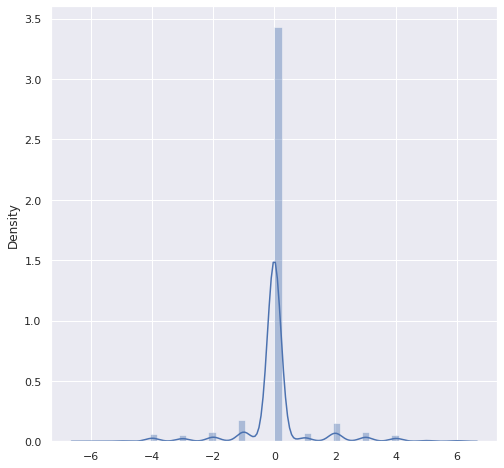

In [ ]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print("Accuracy score: ", accuracy_score(y_test, prediction))
print("Recall score: ", recall_score(y_test, prediction, average = 'weighted'))
print("Precision score: ", precision_score(y_test, prediction, average = 'weighted'))
print("F1 score: ", f1_score(y_test, prediction, average = 'weighted'))

nb = []
nb.append(accuracy_score(y_test, prediction))
nb.append(recall_score(y_test, prediction, average = 'weighted'))
nb.append(precision_score(y_test, prediction, average = 'weighted'))
nb.append(f1_score(y_test, prediction, average = 'weighted'))

Accuracy score:  0.8229434447300771
Recall score:  0.8229434447300771
Precision score:  0.8418010335090321
F1 score:  0.8251175460221583
